In [1]:
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

# 1.3. BigQuery Storage & Spark MLlib - Python

Use the BigQuery storage connector and [Spark MLlib](https://spark.apache.org/docs/latest/ml-guide.html) to build a Linear Regression model and make predictions

### Create Dataproc Cluster with Jupyter

This notebook is designed to be run on Google Cloud Dataproc.

Follow the links below for instructions on how to create a Dataproc Cluster with the Juypter component installed.

* [Tutorial - Install and run a Jupyter notebook on a Dataproc cluster](https://cloud.google.com/dataproc/docs/tutorials/jupyter-notebook)
* [Blog post - Apache Spark and Jupyter Notebooks made easy with Dataproc component gateway](https://medium.com/google-cloud/apache-spark-and-jupyter-notebooks-made-easy-with-dataproc-component-gateway-fa91d48d6a5a)

### Python 3 Kernel

Use a Python 3 kernel (not PySpark) to allow you to configure the SparkSession in the notebook and include the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) required to use the [BigQuery Storage API](https://cloud.google.com/bigquery/docs/reference/storage).

### Scala Version

Check what version of Scala you are running so you can include the correct spark-bigquery-connector jar 

In [1]:
!scala -version

Scala code runner version 2.12.10 -- Copyright 2002-2019, LAMP/EPFL and Lightbend, Inc.


### Create Spark Session

Include the correct version of the spark-bigquery-connector jar

If you are using scala version 2.11 use `'gs://spark-lib/bigquery/spark-bigquery-latest.jar'`.

If you are using scala version 2.12 use `'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'`.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName('1.3. BigQuery Storage &  Spark MLlib - Python')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar') \
  .getOrCreate()

spark.version

'2.4.5'

### Enable repl.eagerEval

This will output the results of DataFrames in each step without the new need to show `df.show()` and also improves the formatting of the output

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Read the data from BigQuery as a Spark Dataframe

In [10]:
table  = 'bigquery-public-data.ml_datasets.credit_card_default'

df_cc_data = spark.read \
  .format("bigquery") \
  .option("table", table) \
  .load()

In [11]:
df_cc_data.printSchema()

root
 |-- id: double (nullable = true)
 |-- limit_balance: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- age: double (nullable = true)
 |-- pay_0: double (nullable = true)
 |-- pay_2: double (nullable = true)
 |-- pay_3: double (nullable = true)
 |-- pay_4: double (nullable = true)
 |-- pay_5: string (nullable = true)
 |-- pay_6: string (nullable = true)
 |-- bill_amt_1: double (nullable = true)
 |-- bill_amt_2: double (nullable = true)
 |-- bill_amt_3: double (nullable = true)
 |-- bill_amt_4: double (nullable = true)
 |-- bill_amt_5: double (nullable = true)
 |-- bill_amt_6: double (nullable = true)
 |-- pay_amt_1: double (nullable = true)
 |-- pay_amt_2: double (nullable = true)
 |-- pay_amt_3: double (nullable = true)
 |-- pay_amt_4: double (nullable = true)
 |-- pay_amt_5: double (nullable = true)
 |-- pay_amt_6: double (nullable = true)
 |-- default_payment_next_month: 

In [74]:
df_cc_data2 = df_cc_data.drop("id", "predicted_default_payment_next_month")
df_cc_data2 = df_cc_data2.withColumn("default_payment_next_month", df_cc_data2["default_payment_next_month"].cast("double"))

In [58]:
df_cc_data2.printSchema()

root
 |-- limit_balance: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- age: double (nullable = true)
 |-- pay_0: double (nullable = true)
 |-- pay_2: double (nullable = true)
 |-- pay_3: double (nullable = true)
 |-- pay_4: double (nullable = true)
 |-- pay_5: string (nullable = true)
 |-- pay_6: string (nullable = true)
 |-- bill_amt_1: double (nullable = true)
 |-- bill_amt_2: double (nullable = true)
 |-- bill_amt_3: double (nullable = true)
 |-- bill_amt_4: double (nullable = true)
 |-- bill_amt_5: double (nullable = true)
 |-- bill_amt_6: double (nullable = true)
 |-- pay_amt_1: double (nullable = true)
 |-- pay_amt_2: double (nullable = true)
 |-- pay_amt_3: double (nullable = true)
 |-- pay_amt_4: double (nullable = true)
 |-- pay_amt_5: double (nullable = true)
 |-- pay_amt_6: double (nullable = true)
 |-- default_payment_next_month: string (nullable = true)



In [59]:
test_list = df_cc_data2.schema.names 

list(set(test_list) - set(categorical_columns))

['pay_amt_6',
 'age',
 'bill_amt_5',
 'bill_amt_2',
 'limit_balance',
 'bill_amt_6',
 'pay_amt_5',
 'pay_amt_4',
 'bill_amt_1',
 'pay_amt_3',
 'bill_amt_4',
 'bill_amt_3',
 'pay_amt_1',
 'pay_amt_2',
 'default_payment_next_month']

In [75]:
# https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
# http://spark.apache.org/docs/latest/ml-features#standardscaler
# https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

categorical_columns= ['sex', 'education_level', 'marital_status', 'pay_0','pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

numeric_col = ['age', 'bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6',
              'pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']


# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

# The encode of indexed vlaues multiple columns
encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]


# Scaling numerical variables
scaled_numeric_col = [col + "_scaled" for col in numeric_col]
numeric_assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in numeric_col]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in numeric_col]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=scaled_numeric_col + [encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline = Pipeline(stages=
                        indexers+ 
                        encoders+
                        numeric_assemblers+
                        scalers+
                        [assembler])
model=pipeline.fit(df_cc_data2)
df_assembler_output = model.transform(df_cc_data2)

df_assembler_output

limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,sex_indexed,education_level_indexed,marital_status_indexed,pay_0_indexed,pay_2_indexed,pay_3_indexed,pay_4_indexed,pay_5_indexed,pay_6_indexed,sex_indexed_encoded,education_level_indexed_encoded,marital_status_indexed_encoded,pay_0_indexed_encoded,pay_2_indexed_encoded,pay_3_indexed_encoded,pay_4_indexed_encoded,pay_5_indexed_encoded,pay_6_indexed_encoded,age_vec,bill_amt_1_vec,bill_amt_2_vec,bill_amt_3_vec,bill_amt_4_vec,bill_amt_5_vec,bill_amt_6_vec,pay_amt_1_vec,pay_amt_2_vec,pay_amt_3_vec,pay_amt_4_vec,pay_amt_5_vec,pay_amt_6_vec,age_scaled,bill_amt_1_scaled,bill_amt_2_scaled,bill_amt_3_scaled,bill_amt_4_scaled,bill_amt_5_scaled,bill_amt_6_scaled,pay_amt_1_scaled,pay_amt_2_scaled,pay_amt_3_scaled,pay_amt_4_scaled,pay_amt_5_scaled,pay_amt_6_scaled,features
50000.0,1,1,2,39.0,0.0,0.0,0.0,0.0,0,0,47174.0,47974.0,48630.0,50803.0,30789.0,15874.0,1800.0,2000.0,3000.0,2000.0,2000.0,2000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2,[1],[1.0])","(7,[1],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(8,[0],[1.0])",[39.0],[47174.0],[47974.0],[48630.0],[50803.0],[30789.0],[15874.0],[1800.0],[2000.0],[3000.0],[2000.0],[2000.0],[2000.0],[4.281273731444187],[0.6522171588009957],[0.6777424443598135],[0.7136179147350928],[0.8206281581895618],[0.5283678323480246],[0.2770162913688778],[0.08618322367158...,[0.06925285801373...,[0.20997992618261...,[0.1505854052889727],[0.11951471686789...,[0.11576785354126...,"(83,[0,1,2,3,4,5,..."
110000.0,2,1,2,29.0,0.0,0.0,0.0,0.0,0,0,48088.0,45980.0,44231.0,32489.0,26354.0,20221.0,2000.0,2010.0,3000.0,3000.0,3000.0,1000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2,[0],[1.0])","(7,[1],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(8,[0],[1.0])",[29.0],[48088.0],[45980.0],[44231.0],[32489.0],[26354.0],[20221.0],[2000.0],[2010.0],[3000.0],[3000.0],[3000.0],[1000.0],[3.1835112362020874],[0.6648539180994252],[0.6495726350036316],[0.6490650624439213],[0.5247994849009049],[0.4522591137646511],[0.35287554666562...,[0.0957591374128671],[0.06959912230380...,[0.20997992618261...,[0.22587810793345...,[0.17927207530184...,[0.05788392677063...,"(83,[0,1,2,3,4,5,..."
270000.0,1,1,2,36.0,0.0,0.0,0.0,2.0,0,0,78630.0,68921.0,46512.0,40335.0,37165.0,22156.0,10076.0,4018.0,14.0,2051.0,2000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,"(2,[1],[1.0])","(7,[1],[1.0])","(4,[0],[1.0])","(11,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(10,[3],[1.0])","(9,[0],[1.0])","(8,[0],[1.0])",[36.0],[78630.0],[68921.0],[46512.0],[40335.0],[37165.0],[22156.0],[10076.0],[4018.0],[14.0],[2051.0],[2000.0],[0.0],[3.951944982871557],[1.0871207698419108],[0.9736667154650999],[0.6825374552777841],[0.6515370501855398],[0.6377859134500743],[0.3866431240751453],[0.48243453428602...,[0.13912899174959...,[9.79906322185531...,[0.15442533312384...,[0.11951471686789...,[0.0],"(83,[0,1,2,3,4,5,..."
130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0,0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2,[1],[1.0])","(7,[1],[1.0])","(4,[1],[1.0])","(11,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(10,[0],[1.0])","(9,[0],[1.0])","(8,[0],[1.0])",[45.0],[58180.0],[59134.0],[61156.0],[62377.0],[63832.0],[65099.0],[2886.0],[2908.0],[2129.0],[2354.0],[2366.0],[2291.0],[4.9399312285894466],[0.8043836498715804],[0.8354029621205905],[0.8974299237824253],[1.007584643099626],[1.0954163978836309],[1.136039029345003],[0.1381804352867672],[0.10069365555197...,[0.14901575428092...,[0.1772390220251209],[0.1413859100547254],[0.13261207623152...,"(83,[0,1,2,3,4,5,..."
50000.0,1,1,2,24.0,0.0,0.0,0.0,0.0,0,0,42058.0,35340.0,22110.0,19837.0,19855.0,2

### Limit no of rows and cache data

limit the no of rows that will be read for this example to run faster. 

The DataFrame is cached as LinearRegression is iterative and this avoids re-reading the data from BigQuery Storage for each iteration

In [5]:
limit = 10000

df_natality_select = df_natality_table \
.select("limit_balance", "sex", "education_level", "marital_status") \
.where("""
weight_pounds IS NOT NULL 
AND mother_age IS NOT NULL
AND father_age IS NOT NULL
AND gestation_weeks IS NOT NULL
AND weight_gain_pounds IS NOT NULL
AND apgar_5min IS NOT NULL
""") \
.limit(limit) \
.cache()

df_natality_select.printSchema()

root
 |-- weight_pounds: double (nullable = true)
 |-- mother_age: long (nullable = true)
 |-- father_age: long (nullable = true)
 |-- gestation_weeks: long (nullable = true)
 |-- weight_gain_pounds: long (nullable = true)
 |-- apgar_5min: long (nullable = true)



### Optional 
#### Run count to check no of rows in DataFrame

In [6]:
df_natality_select.count()

10000

### Create an input DataFrame for Spark MLlib using VectorAssembler

Spark MLlib estimators expect a single vector column for features. Multiple columns can be converted to a single vector column using [VectorAssembler](https://spark.apache.org/docs/latest/ml-features#vectorassembler)

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["mother_age", "father_age", "gestation_weeks", "weight_gain_pounds", "apgar_5min"],
    outputCol="features")

df_assembler_output = assembler.transform(df_natality_select)
df_assembler_output

weight_pounds,mother_age,father_age,gestation_weeks,weight_gain_pounds,apgar_5min,features
7.31273323054,37,39,36,7,9,"[37.0,39.0,36.0,7..."
7.5618555866,38,40,41,99,9,"[38.0,40.0,41.0,9..."
5.8753192823,31,35,38,4,9,"[31.0,35.0,38.0,4..."
7.49792153062,33,30,40,30,9,"[33.0,30.0,40.0,3..."
10.06189763768,38,40,43,14,9,"[38.0,40.0,43.0,1..."
8.24969784404,36,39,37,50,9,"[36.0,39.0,37.0,5..."
5.68572173698,47,47,34,25,3,"[47.0,47.0,34.0,2..."
7.81097794266,43,50,40,28,10,"[43.0,50.0,40.0,2..."
6.834330122,34,39,40,99,99,"[34.0,39.0,40.0,9..."
8.2232423726,40,43,40,99,99,"[40.0,43.0,40.0,9..."


### Create a training data DataFrame

Create a training data DataFrame with just the features and label column.

Cache the training data table.

In [76]:
df_training_data = df_assembler_output \
.select("features", "default_payment_next_month") \
.withColumnRenamed("default_payment_next_month","label")

df_training_data.cache()
df_training_data

features,label
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0
"(83,[0,1,2,3,4,5,...",0.0


### Split the data into training and test sets

30% held out for testing

In [96]:
(df_training, df_test) = df_training_data.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(df_training.count()))
print("Test Dataset Count: " + str(df_test.count()))

Training Dataset Count: 2107
Test Dataset Count: 858


### Construct a new LinearRegression object and fit the training data

Import and use and the [LinearRegression model](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)

In [97]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(df_training)

# rf = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# model = rf.fit(df_training)

### Print the coefficients and intercept for linear regression

Text(0, 0.5, 'Beta Coefficients')

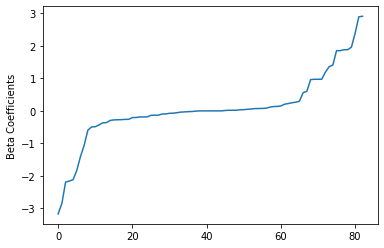

In [101]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

Training set areaUnderROC: 0.7949996547782526


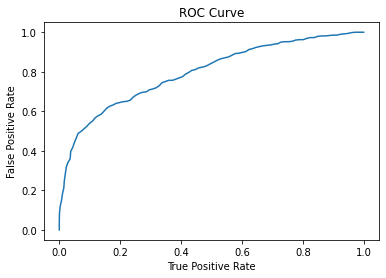

In [103]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

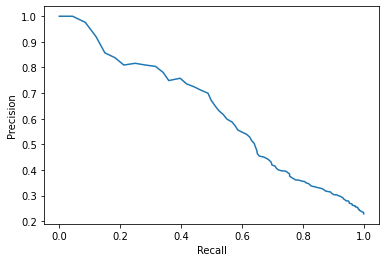

In [104]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [105]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

NameError: name 'BinaryClassificationEvaluator' is not defined

In [106]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(df_training)
predictions = gbtModel.transform(df_test)
predictions.select("prediction","label","probability","features").show(5)

+----------+-----+--------------------+--------------------+
|prediction|label|         probability|            features|
+----------+-----+--------------------+--------------------+
|       0.0|  0.0|[0.86215617013175...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.86215617013175...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.86215617013175...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.87014322885512...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.85853094814142...|(83,[0,1,2,3,4,5,...|
+----------+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(df_training)
predictions = cvModel.transform(df_test)
evaluator.evaluate(predictions)

0.8543123543123543

In [94]:
predictions = model.transform(df_test)
predictions.select("prediction","label","probability","features").show(5)



+----------+-----+--------------------+--------------------+
|prediction|label|         probability|            features|
+----------+-----+--------------------+--------------------+
|       0.0|  0.0|[0.92304451239222...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.90625802404426...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.89542354428623...|(83,[0,1,2,3,4,5,...|
|       0.0|  1.0|[0.88590437229345...|(83,[0,1,2,3,4,5,...|
|       0.0|  0.0|[0.85374039517577...|(83,[0,1,2,3,4,5,...|
+----------+-----+--------------------+--------------------+
only showing top 5 rows



In [95]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))


Accuracy = 0.813424


### Summarize the model over the training data and print metrics

In [13]:
trainingSummary = model.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

trainingSummary.residuals

numIterations: 1
objectiveHistory: [0.0]
RMSE: 1.205822
r2: 0.391391


residuals
-0.06427120097813521
1.4054942809910722
1.615669149519861
1.8461326439359498
0.07032860053297885
-1.43244194979542
-1.7109598506752508
2.995209709060892
0.21341987241150395
1.267985188300587


### Make predictions on test data

In [15]:
predictions = model.transform(df_test)
predictions.select("prediction", "label", "features")

prediction,label,features
6.735331281174319,6.25671899556,"[13.0,17.0,38.0,6..."
7.315888778823852,8.437090766739999,"[14.0,16.0,40.0,1..."
7.372168136194236,7.50012615324,"[14.0,17.0,40.0,9..."
6.7400855825755,5.37486994756,"[14.0,20.0,38.0,9..."
5.682308546399798,5.8753192823,"[14.0,99.0,35.0,9..."
4.33033463412318,3.0622208191799998,"[15.0,18.0,29.0,9..."
7.134663854645244,9.06320359082,"[15.0,18.0,39.0,3..."
6.58610098912506,8.000575487979999,"[15.0,19.0,37.0,4..."
7.307916501843823,6.4374980503999994,"[15.0,20.0,40.0,9..."
6.53890439878406,5.8753192823,"[15.0,99.0,38.0,1..."


### Select (prediction, true label) and compute test error

In [16]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.18882
